# Performing Brain Tissue Segmentation 


# Drive authentication

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Change directory()
%cd "drive/My Drive/MISAProject/dataset/"

# Introduction:

---

Through out this notebook, it will focus entirely on MRI brain tissue segmentation using the U-NET architecture. The second part is structured as follows:

1. The U-NET model
2. Data preparation
3. Training the network
4. Inference
5. Evaluation
6. Conclusion

First of all, import or install all necessary libraries. We will make use of [ANTS](https://github.com/ANTsX/ANTsPy), which is like a super-power to manage and process `nifti` images. 


In [ ]:
!pip install https://github.com/ANTsX/ANTsPy/releases/download/v0.1.8/antspy-0.1.7-cp36-cp36m-linux_x86_64.whl
!pip install statsmodels
import os
import random
import torch
import ants
import numpy as np

# upload files (weird)
!git clone https://github.com/sergivalverde/MAIA_seminar.git

%load_ext autoreload
%autoreload 2

# 1. The U-NET model: 
---

The encoder-decoder U-NET model was proposed by [Ronneberger et al. 2015](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/) in the context of biomedical image segmentation (microscopy imaging). Encoder-decoder models are very similar to [autoencoders](https://en.wikipedia.org/wiki/Autoencoder), so the encoding part compresses the input image into the latent space, meaning that we end up with a very efficient compressed version of the image with a lot less information. 

Based on the latent space, the decoder part reconstructs the image back. Compared to other encoder-decoder architectures like the [SegNET](https://mi.eng.cam.ac.uk/projects/segnet/), the U-NET model introduced the copy and crop elements, so activations for each of the encoder layers were concatenated (or added) to the same level decoding layers in order to help to reconstruct the image structure prior to segmentation. 

<img src="https://miro.medium.com/max/2640/1*J3t2b65ufsl1x6caf6GiBA.png" width="600" height="600" />

Although the original U-NET was proposed for 2D images, very rapidly 3D implementations arised [Çiçek et al. 2016](https://arxiv.org/abs/1606.06650). However, dealing with entire MRI volumes is not always possible, due to hardware memory limitations, etc... So, in most cases, patch-wise implementations of the same 3D models are used for different tasks such as brain tissue segmentation [Bernal et al. 2019](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8754679). For our problem in hand, we are going to follow the same 3D patch-wise approach. 

Let's now define our first patch-wise `Unet` model in PyTorch:

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, input_size, output_size):

        super(Unet, self).__init__()

        # conv1 down
        self.conv1 = nn.Conv3d(in_channels=input_size,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # max-pool 1
        self.pool1 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=2,
                               stride=2)
        # conv2 down
        self.conv2 = nn.Conv3d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # max-pool 2
        self.pool2 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=2,
                               stride=2)
        # conv3 down
        self.conv3 = nn.Conv3d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # max-pool 3
        self.pool3 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=2,
                               stride=2)
        # conv4 down (latent space)
        self.conv4 = nn.Conv3d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose3d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)        
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv3d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose3d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2) 
        self.conv6 = nn.Conv3d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose3d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv3d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv3d(in_channels=32,
                               out_channels=output_size,
                               kernel_size=1)

    def forward(self, x):

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)
        
        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))
        
        # output layer (2 classes)
        # we use a softmax layer to return probabilities for each class
        out = F.softmax(self.conv8(x7), dim=1) 
        
        return out

# 2. Data preparation:
---

Let's now obtain some data to train and test the model. In this experiment we are using the raw datas provided which contains four label classes,  0: background, 1: CSF, 2: GM, 3: WM

In [0]:
!rm -rf dataset/RAW.DS_Store
!rm -rf RAW/train/.DS_Store
!rm -rf RAW/val/.DS_Store
!rm -rf RAW/test/.DS_Store

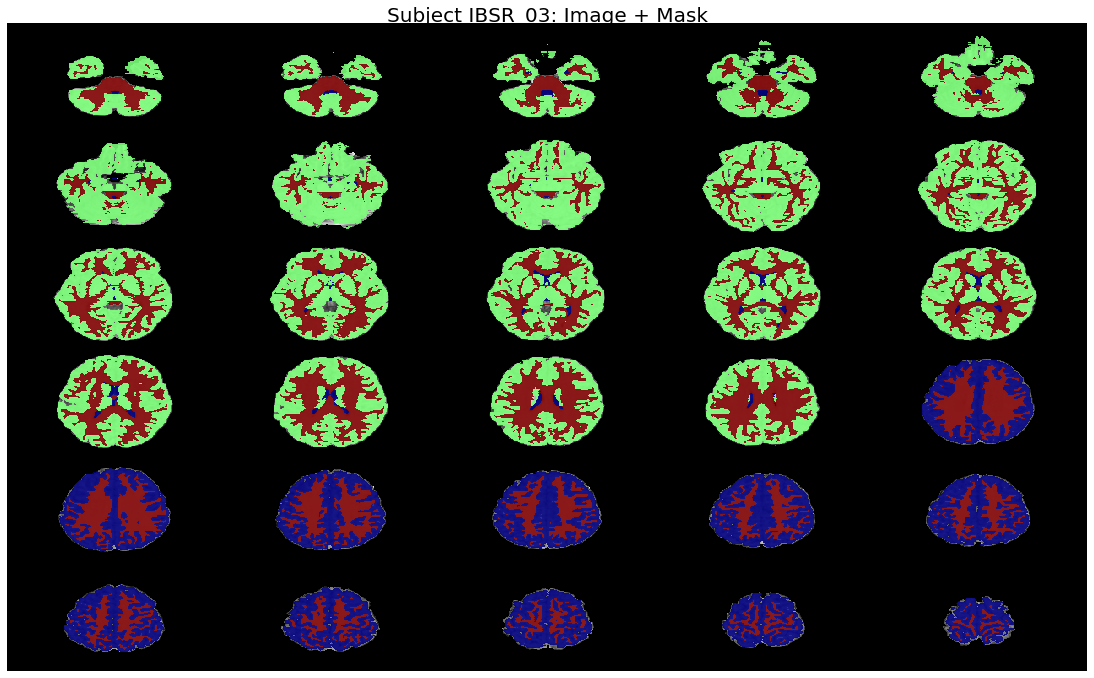

In [6]:
mri_subject = ants.image_read('RAW/train/IBSR_03/IBSR.nii.gz')
lesion_mask = ants.image_read('RAW/train/IBSR_03/IBSR_seg.nii.gz')
mri_subject.plot(overlay=lesion_mask, nslices=30, axis=2, title='Subject IBSR_03: Image + Mask')

## 2.1 Loading data efficiently:

Similar to other *Deep Learning* toolkits, Pytorch also incorporates some objects to deal with data efficiently. In particular, we will make use of `Datasets` and `Dataloaders`:

* `Datasets` objects are used to build customs datasets from our data, permitting us to manage training data very efficiently. For instance, imagine a custom dataset with hundreds of MRI subjects containing several input modalities. Loading and managing this amount of information may be tricky in some situations, so a custom `Dataset` that loads the data when necessary is convenient. 


* `Dataloaders` take `Datasets` as input and permits to automatically collate individual fetched data samples into batches via arguments. `Dataloaders` yield consecutive batch samples during the training loop, handling all the data requirements via the `Dataset` object. 

In order to speed up this tutorial, we are going to make use of some helper funcions to deal with MRI data and convert them into PyTorch `dataloaders` (see `utils.py` for more information). 


Let's now train our `Unet` model using the PROVIDED data. Before start training, several steps have to be taken into account:  
1. Building the proper training data structures using the PyTorch `Dataset` and `Dataloader` objects.
2. Building the training loop. 

With the aim  to unify all the hyper-parameters and training options, we will define a dictionary `options` that we will populate with new values: 

In [0]:
options = {}

# training data path
options['training_path'] = 'RAW/train/'

# testing data path 
options['test_path'] = 'RAW/test'
options['val_path'] = 'RAW/val/'

# input modality names
options['input_data'] = ['IBSR.nii.gz']

# ground-truth name
options['gt_data'] = 'IBSR_seg.nii.gz'

## 2.2 Training generators: 

We are going to use the helper class `MRI_DataPatchLoader` from `utils.py` to generate a `Dataset` object based on our data. `MRI_DataPathLoader` requires an input dictionary with all image paths, image labels, and some other options for patch generation and normalization that we will cover in a few minutes. 

Additionally, the `MRI_DataPathLoader` also requires a third dictionary containing the paths a ROI mask from within the patch sampling should be performed. This mask is very handful to guide the sampling process, for instance to remove background voxels, deal with class imbalance etc...

For our example, let's generate a ROI mask for each subject simply with the binary brain mask:

In [0]:
import os
options['roi'] = 'brainmask.nii.gz'

def mask_image(im):
    return (im > 0).astype('float32')

for scan_id in os.listdir(options['training_path']):
    scan = ants.image_read(os.path.join(options['training_path'], 
                                        scan_id, 
                                        'IBSR.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['training_path'], 
                                       scan_id, 
                                       options['roi']))
                                      
    
for scan_id in os.listdir(options['val_path']):
    scan = ants.image_read(os.path.join(options['val_path'], 
                                        scan_id, 
                                        'IBSR.nii.gz')) 
    brainmask = ants.image_clone(scan).apply(mask_image)
    brainmask.to_filename(os.path.join(options['val_path'], 
                                       scan_id, 
                                       options['roi']))

Now, we can define the input dictionaries for training and validation. Here we train on whole training data and validate on whole validation data. 

In [0]:
import os
training_scans = os.listdir(options['training_path'])
random.shuffle(training_scans)

validation_scans = os.listdir(options['val_path'])
random.shuffle(validation_scans)

training_data = training_scans[:]
validation_data = validation_scans[:]

input_train_data = {scan: [os.path.join(options['training_path'], scan, d)
                         for d in options['input_data']]
                  for scan in training_data}

input_train_labels = {scan: [os.path.join(options['training_path'], scan, options['gt_data'])] 
                      for scan in training_data}

input_train_rois = {scan: [os.path.join(options['training_path'], scan, options['roi'])] 
                      for scan in training_data}

input_val_data = {scan: [os.path.join(options['val_path'], scan, d)
                         for d in options['input_data']]
                  for scan in validation_data}

input_val_labels = {scan: [os.path.join(options['val_path'], scan, options['gt_data'])] 
                    for scan in validation_data}

input_val_rois = {scan: [os.path.join(options['val_path'], scan, options['roi'])] 
                      for scan in validation_data}

Now we build the `Datasets` for training and validation data. Here, we need to define the patch size (in 3D), and how we are going to sample the images. Also consider image normalization (take it into account on testing also!). We [normalize](https://datascience.stackexchange.com/questions/32109/zero-mean-and-unit-variance) images with `mean=0` and `std=1`. In particular, we are going to use:

* Patch size of `32x32x32`
* Sampling step of `32x32x32`
* Batch size of `8`



In [10]:
from MAIA_seminar.utils import MRI_DataPatchLoader
from torch.utils.data import DataLoader

# additional options for patch size, sampling step, normalization, etc...
options['patch_size'] = (32, 32, 32)
options['sampling_step'] = (32, 32, 32)
options['normalize'] = True 
options['batch_size'] = 8

print('Training data: ')
training_dataset = MRI_DataPatchLoader(input_data=input_train_data,
                                       labels=input_train_labels,
                                       rois=input_train_rois,
                                       patch_size=options['patch_size'],
                                       sampling_step=options['sampling_step'],
                                       normalize=options['normalize'])

training_dataloader = DataLoader(training_dataset, 
                                 batch_size=options['batch_size'],
                                 shuffle=True)

print('Validation data: ')
validation_dataset = MRI_DataPatchLoader(input_data=input_val_data,
                                        labels=input_val_labels,
                                        rois=input_val_rois,
                                        patch_size=options['patch_size'],
                                        sampling_step=options['sampling_step'],
                                        normalize=options['normalize'])

validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size=options['batch_size'],
                                   shuffle=True)

/usr/local/lib/python3.6/dist-packages/nibabel/testing/__init__.py:21: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


Training data: 
> DATA: Loaded scan IBSR_05 roi size: 1040178 label_size:  950111
> DATA: Loaded scan IBSR_16 roi size: 1460808 label_size:  1385945
> DATA: Loaded scan IBSR_18 roi size: 1668281 label_size:  1590195
> DATA: Loaded scan IBSR_01 roi size: 1147470 label_size:  1093813
> DATA: Loaded scan IBSR_09 roi size: 1002429 label_size:  927415
> DATA: Loaded scan IBSR_08 roi size: 868943 label_size:  787260
> DATA: Loaded scan IBSR_07 roi size: 867764 label_size:  799514
> DATA: Loaded scan IBSR_04 roi size: 1069342 label_size:  1027700
> DATA: Loaded scan IBSR_06 roi size: 1078395 label_size:  977824
> DATA: Loaded scan IBSR_03 roi size: 951358 label_size:  899576
> DATA: Training sample size: 355
Validation data: 
> DATA: Loaded scan IBSR_12 roi size: 954168 label_size:  861321
> DATA: Loaded scan IBSR_13 roi size: 1058473 label_size:  1022741
> DATA: Loaded scan IBSR_17 roi size: 1565803 label_size:  1502254
> DATA: Loaded scan IBSR_11 roi size: 958119 label_size:  889996
> DATA:

# 3. Training the network:

---


Finally we can build our training loop to optimize the `Unet` model based on the same principles we covered in the first part of this tutorial. Basically, what we are going to do is to iterate the training dataset for a number of epochs, saving the weights of the model accordingly. 

For this first example, we are going to use the [cross-entropy](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) loss and the [Adadelta](https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta) optimizer:



In [11]:
from torch.optim import Adadelta

# mkdir for stored models
!mkdir models

# Define the Unet model 
# 1 input channels (T1)
# 4 output classes (0: background, 1: CSF, 2: GM, 3: WM)
lesion_model = Unet(input_size=1, output_size=4)
model_name = 'CSF_WM_GM'

# some training options
options['gpu_use'] = True
options['num_epochs'] = 100

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# define the optimizer
optimizer = Adadelta(lesion_model.parameters())

# send the model to the device
lesion_model = lesion_model.to(device)

# training loop
training = True
epoch = 1
try:
    while training:
    
        # epoch specific metrics
        train_loss = 0
        train_accuracy = 0
        val_loss = 0
        val_accuracy = 0
        
        # -----------------------------
        # training samples
        # -----------------------------
        
        # set the model into train mode
        lesion_model.train()
        for a, batch in enumerate(training_dataloader):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 2, 32, 32, 32]
                # y = [32, 1, 32, 32, 32]
    
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # clear gradients
                optimizer.zero_grad()
                
                # infer the current batch 
                pred = lesion_model(x)
                
                # compute the loss. 
                # we ignore the index=2
                loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                       y.squeeze(dim=1).long())
                #loss = F.l1_loss(pred, y)
                
                train_loss += loss.item()
                
                # backward loss and next step
                loss.backward()
                optimizer.step()

                # compute the accuracy
                pred = pred.max(1, keepdim=True)[1]
                batch_accuracy = pred.eq(y.view_as(pred).long())
                train_accuracy += (batch_accuracy.sum().item() / np.prod(y.shape))
                
                
        # -----------------------------
        # validation samples
        # -----------------------------
    
        # set the model into train mode
        lesion_model.eval()
        for b, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)
                
                # infer the current batch 
                with torch.no_grad():
                    pred = lesion_model(x)
                
                    # compute the loss. 
                    # we ignore the index=2
                    loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                           y.squeeze(dim=1).long())
                    #loss = F.l1_loss(pred, y)
                    val_loss += loss.item()
                
                    # compute the accuracy 
                    pred = pred.max(1, keepdim=True)[1]
                    batch_accuracy = pred.eq(y.view_as(pred).long())
                    val_accuracy += batch_accuracy.sum().item() / np.prod(y.shape)
                
        
        # compute mean metrics
        train_loss /= (len(training_dataloader))
        #train_accuracy /= (a + 1)
        train_accuracy /= (len(training_dataloader))

        val_loss /= (len(validation_dataloader))
        #val_accuracy /= (b + 1)
        val_accuracy /= (len(validation_dataloader))
    
        print('Epoch {:d} train_loss {:.4f} train_acc {:.4f} val_loss {:.4f} val_acc {:.4f}'.format(
        epoch, 
        train_loss, 
        train_accuracy,
        val_loss,
        val_accuracy))
        # update epochs
        epoch += 1
        
        # save weights
        torch.save(lesion_model.state_dict(), 
                  os.path.join('models', 'model' + str(epoch) + '.pt'))

        if epoch >= options['num_epochs']:
            training = False
except KeyboardInterrupt:
    pass        

mkdir: cannot create directory ‘models’: File exists
Epoch 1 train_loss 0.5351 train_acc 0.8075 val_loss 0.4410 val_acc 0.8318
Epoch 2 train_loss 0.3644 train_acc 0.8766 val_loss 0.3535 val_acc 0.8867
Epoch 3 train_loss 0.3554 train_acc 0.8767 val_loss 0.3400 val_acc 0.8769
Epoch 4 train_loss 0.3484 train_acc 0.8763 val_loss 0.3100 val_acc 0.8950
Epoch 5 train_loss 0.3313 train_acc 0.8828 val_loss 0.3462 val_acc 0.8747
Epoch 6 train_loss 0.3265 train_acc 0.8823 val_loss 0.2897 val_acc 0.8971
Epoch 7 train_loss 0.3232 train_acc 0.8828 val_loss 0.3212 val_acc 0.8820
Epoch 8 train_loss 0.3014 train_acc 0.8897 val_loss 0.3005 val_acc 0.8879
Epoch 9 train_loss 0.2986 train_acc 0.8891 val_loss 0.3012 val_acc 0.8945
Epoch 10 train_loss 0.2973 train_acc 0.8894 val_loss 0.2971 val_acc 0.8885
Epoch 11 train_loss 0.2940 train_acc 0.8890 val_loss 0.2783 val_acc 0.8985
Epoch 12 train_loss 0.2852 train_acc 0.8924 val_loss 0.2847 val_acc 0.8972
Epoch 13 train_loss 0.2857 train_acc 0.8911 val_loss 0.2

# 4. Inference:

---


Once we have trained our first `Unet` model, we can infer some testing cases to see how well it performs. In contrast to training, we do not make use of data generators for infering lesions on testing scans. Again, we are  going to use some additional helper functions included in `utils.py` that will help us to extract the image patches to infer the model:

* `get_inference_patches` will extract $[num_{samples}, 2, 32, 32, 32]$ patches from the input image along with their coordenates $(x,y,z)$. 

* `reconstruct_image` will take the predicted patches and reconstruct them back as an image using the coordinates as a  base. 

We evaluate the model on the extracted patches. Note that inference is very similar to validation, but we store the results in the `lesion_out` array:

## Test Image No. 1 (IBSR_02) reconstruction

In [12]:
from MAIA_seminar.utils import get_inference_patches, reconstruct_image

scan_path = os.path.join(options['test_path'], 'IBSR_02')
scan = ants.image_read(os.path.join(scan_path, 'IBSR.nii.gz'))
print(scan.shape)

infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                          input_data=options['input_data'],
                                          roi=options['roi'],
                                          patch_shape=options['patch_size'],
                                          step=options['sampling_step'],
                                          normalize=options['normalize'])


lesion_out = np.zeros((infer_patches.shape[0], 4, 32, 32, 32)).astype('float32')
batch_size = options['batch_size']

# model
lesion_model.eval()
with torch.no_grad():
    for b in range(0, len(lesion_out), batch_size):
        x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
        pred = lesion_model(x)
        # save the result back from GPU to CPU --> numpy
        lesion_out[b:b+batch_size] = pred.cpu().numpy() 

(256, 128, 256)


In [ ]:
# reconstruct image takes the inferred patches, the patches coordenates and the image size as inputs

a = np.argmax (lesion_out, axis = 1)
lesion_prob = reconstruct_image(a, 
                                coordenates, 
                                scan.shape)

# save as nifti image is necessary
lesion_img1 = ants.from_numpy(lesion_prob)
lesion_img1 = ants.copy_image_info(scan, lesion_img1)
lesion_img1.to_filename(os.path.join(options['test_path'], 'IBSR_02', 'EXP_04_IBSR_02_Reconstructed_Image.nii.gz'))

scan.plot_ortho(figsize=1.0)
lesion_img1.plot_ortho(figsize=1.0)

# 5. Evaluation:
---

In order to evaluate the results, we use standard metrics for lesion segmentation such as:
* `DSC:` Dice **segmentation** coefficient 
* `TPF:` **Lesion-wise** true positive rate (Sensitivity) 
* `PPV:` **Lesion-wise** positive predictive value (PPV)(precision)

Let's infer all the test images and evaluate the results in average:

In [20]:
import pandas as pd
from MAIA_seminar.metrics import DSC_seg, TPF_det, PPV_det
# obtain a list of scans
#test_scans = os.listdir(options['test_path'])
val_scans = os.listdir(options['val_path'])

# iterate through the scans and evaluate the results
metrics = np.zeros((len(val_scans), 3))

for i, scan_name in enumerate(val_scans):
    
    scan_path = os.path.join(options['val_path'], scan_name)
    scan = ants.image_read(os.path.join(scan_path, 'IBSR.nii.gz'))

    infer_patches, coordenates = get_inference_patches(scan_path=scan_path,
                                              input_data=options['input_data'],
                                              roi=options['roi'],
                                              patch_shape=options['patch_size'],
                                              step=options['sampling_step'],
                                              normalize=options['normalize'])

    lesion_out = np.zeros((infer_patches.shape[0], 4, 32, 32, 32)).astype('float32')
    batch_size = options['batch_size']

    # model evaluation 
    lesion_model.eval()
    with torch.no_grad():
        for b in range(0, len(lesion_out), batch_size):
            x = torch.tensor(infer_patches[b:b+batch_size]).to(device)
            pred = lesion_model(x)
            lesion_out[b:b+batch_size] = pred.cpu().numpy()
        
    # Reconstruct image 
    a = np.argmax (lesion_out, axis = 1)
    lesion_prob = reconstruct_image(a, 
                                coordenates, 
                                scan.shape)
 
    # save as nifti image is necessary
    lesion_img1 = ants.from_numpy(lesion_prob)
    lesion_img1 = ants.copy_image_info(scan, lesion_img1)
    lesion_img1.to_filename(os.path.join(options['val_path'], 'scan_name', 'EXP_04_Reconstructed_Image.nii.gz'))

    # evaluate the results    
    gt = ants.image_read(os.path.join(scan_path, 'IBSR_seg.nii.gz'))
    
    dsc_metric = DSC_seg(gt.numpy(), lesion_prob)
    tpf_metric = TPF_det(gt.numpy(), lesion_prob)
    ppv_metric = PPV_det(gt.numpy(), lesion_prob)

    metrics[i] = [dsc_metric, tpf_metric, ppv_metric]
    
    print('SCAN:', scan_name, 'Dice: ', dsc_metric, 'TPF:', tpf_metric, 'PPV:', ppv_metric)

# we use PANDAS to describe data :)
m = pd.DataFrame(metrics, columns=['DSC', 'TPF', 'PPV'])
m.describe().T


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/content/drive/My Drive/MISAProject/dataset/MAIA_seminar/utils.py:458: RuntimeWarning: invalid value encountered in true_divide
  out_image /= freq_count


SCAN: IBSR_11 Dice:  0.8570959748645316 TPF: 1.0 PPV: 0.5319148936170213
SCAN: IBSR_17 Dice:  0.892710029941268 TPF: 1.0 PPV: 0.5625
SCAN: IBSR_12 Dice:  0.8607843600403124 TPF: 1.0 PPV: 0.5681818181818182
SCAN: IBSR_14 Dice:  0.8660045593714111 TPF: 0.5 PPV: 1.0
SCAN: IBSR_13 Dice:  0.8776671268210189 TPF: 1.0 PPV: 0.625


,count,mean,std,min,25%,50%,75%,max
DSC,5.0,0.870852,0.014477,0.857096,0.860784,0.866005,0.877667,0.89271
TPF,5.0,0.900000,0.223607,0.500000,1.000000,1.000000,1.000000,1.00000
PPV,5.0,0.657519,0.194382,0.531915,0.562500,0.568182,0.625000,1.00000
